# Short Term Water Demand Forecasting with Statistical and AI Methods

### Oscar Wooding
Department of Civil and Environmental Engineering, Imperial College London

### Initial Statistical Analysis


In [47]:
# imports 
import sys
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import rc
import matplotlib_inline
import datetime as dt
import warnings
from scipy import stats

%matplotlib inline

# improve matlab output
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

rc('text', usetex=False)
plt.rc('font', size=10)          # controls default text sizes
plt.rc('axes', titlesize=12)     # fontsize of the axes title
plt.rc('axes', labelsize=11)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10)    # fontsize of the tick labels
plt.rc('legend', fontsize=10)    # legend fontsize
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

# adjust the format of the data set
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)

warnings.filterwarnings("ignore")


### *Load*

In [48]:
# load inflow data
inflow_data = pd.read_csv("../data/InflowData.csv")

# make list with dma names
dma_list = list(inflow_data.columns.values[1:])

# male list with dma description
dma_descripton = ["Hospital district",
                   "Residential district in the countryside",
                   "Residential district in the countryside",
                   "Suburban residential/commercial district",
                   "Residential/commercial district close to the city centre",
                   "Suburban district including sport facilities and office buildings",
                   "Residential district close to the city centre",
                   "City centre district",
                   "Commercial/industrial district close to the port",
                   "Commercial/industrial district close to the port"]

# make list with information of users supplied
users_supplied = [162,531,607,2094,7955,1135,3180,2901,425,776]

# make list with average net inflow
av_net_inflo = [8.4,9.6,4.3,32.9,78.3,8.1,25.1,20.8,20.6,26.4]

# change index of inflow dataframe to time step
inflow_data = inflow_data.set_index('date_time')

# change index format to datetime
inflow_data.index = pd.to_datetime(inflow_data.index, format="%d/%m/%Y %H:%M")

# # print first two rows
inflow_data.head(3)


,dma_a,dma_b,dma_c,dma_d,dma_e,dma_f,dma_g,dma_h,dma_i,dma_j
date_time,,,,,,,,,,
2021-01-01 00:00:00,NaN,NaN,3.70,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 01:00:00,NaN,NaN,3.56,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 02:00:00,NaN,NaN,3.27,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
# load weather data
weather_data = pd.read_csv("../data/WeatherData.csv")

# change index of weather dataframe to time step
weather_data = weather_data.set_index('date_time')

# change index format to datetime
weather_data.index = pd.to_datetime(weather_data.index, format="%d/%m/%Y %H:%M")

# # print first two rows
weather_data.head(3)


,rain_depth,air_temp,air_humid,windspeed
date_time,,,,
2021-01-01 00:00:00,0.00,7.20,79.00,9.00
2021-01-01 01:00:00,0.00,7.30,79.00,6.00
2021-01-01 02:00:00,0.00,7.60,78.00,4.00


### *Visualise*

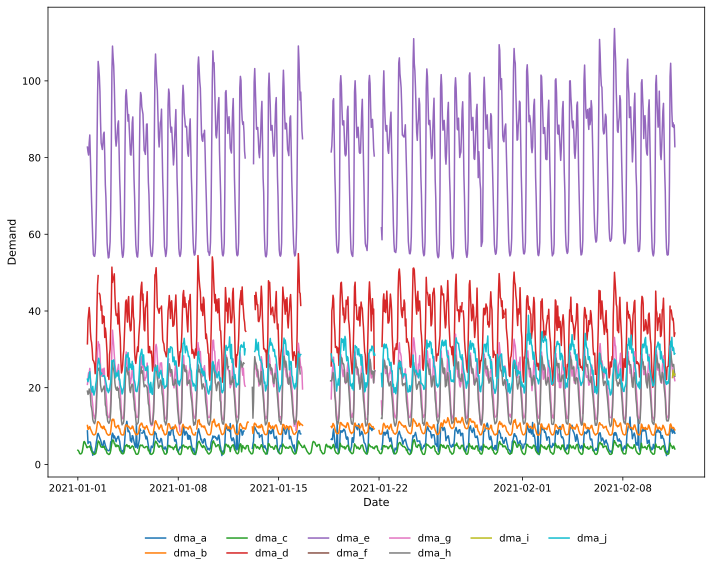

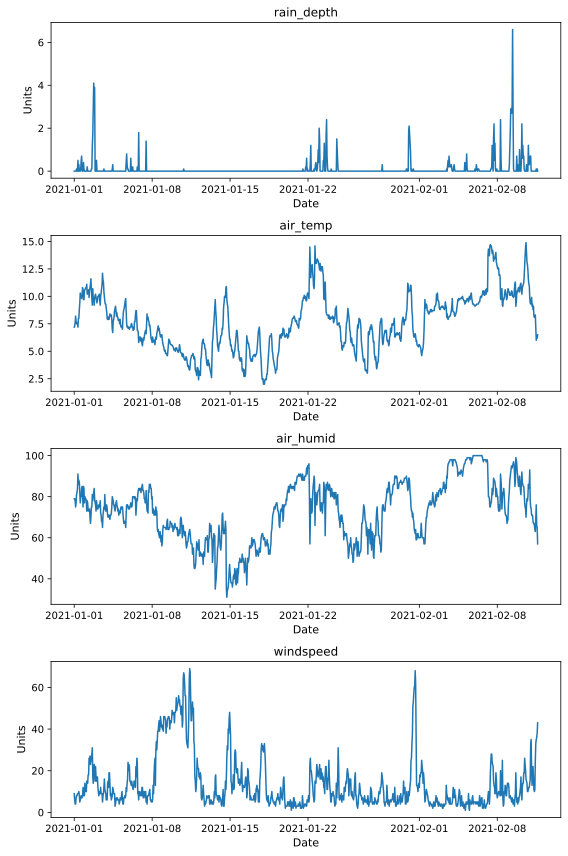

In [50]:
# total dataset
# demand
no_timesteps, no_dma = inflow_data.shape

fig, axs = plt.subplots(1, 1, figsize=(10, 8))

axs.plot(inflow_data.iloc[0:1000, :], label=inflow_data.columns)
axs.set_xlabel('Date')
axs.set_ylabel('Demand')

leg = axs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
    fancybox=False, shadow=False, ncol=6, edgecolor='w', borderpad=0.5)
leg.get_frame().set_linewidth(0.5)

fig.tight_layout()
plt.show()

# weather
fig, axs = plt.subplots(4, 1, figsize=(8, 12))

for i, col in enumerate(weather_data.columns): 
    axs[i].plot(weather_data.iloc[0:1000, :][col], label=col)
    axs[i].set_title(col)
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Units')

fig.tight_layout()
plt.show()


In [51]:
# correlation between different dma
inflow_data.corr()


,dma_a,dma_b,dma_c,dma_d,dma_e,dma_f,dma_g,dma_h,dma_i,dma_j
dma_a,1.00,0.57,0.60,0.40,0.52,0.03,0.58,0.53,0.45,0.62
dma_b,0.57,1.00,0.91,0.63,0.67,0.09,0.67,0.53,0.34,0.55
dma_c,0.60,0.91,1.00,0.63,0.71,0.13,0.73,0.55,0.32,0.56
dma_d,0.40,0.63,0.63,1.00,0.90,0.53,0.78,0.81,0.38,0.63
dma_e,0.52,0.67,0.71,0.90,1.00,0.53,0.90,0.91,0.52,0.76
dma_f,0.03,0.09,0.13,0.53,0.53,1.00,0.57,0.56,0.21,0.35
dma_g,0.58,0.67,0.73,0.78,0.90,0.57,1.00,0.84,0.44,0.70
dma_h,0.53,0.53,0.55,0.81,0.91,0.56,0.84,1.00,0.60,0.83
dma_i,0.45,0.34,0.32,0.38,0.52,0.21,0.44,0.60,1.00,0.86
dma_j,0.62,0.55,0.56,0.63,0.76,0.35,0.70,0.83,0.86,1.00


In [52]:
# correlation between external factors
weather_data.corr()


,rain_depth,air_temp,air_humid,windspeed
rain_depth,1.00,-0.02,0.15,0.04
air_temp,-0.02,1.00,-0.22,-0.10
air_humid,0.15,-0.22,1.00,-0.33
windspeed,0.04,-0.10,-0.33,1.00


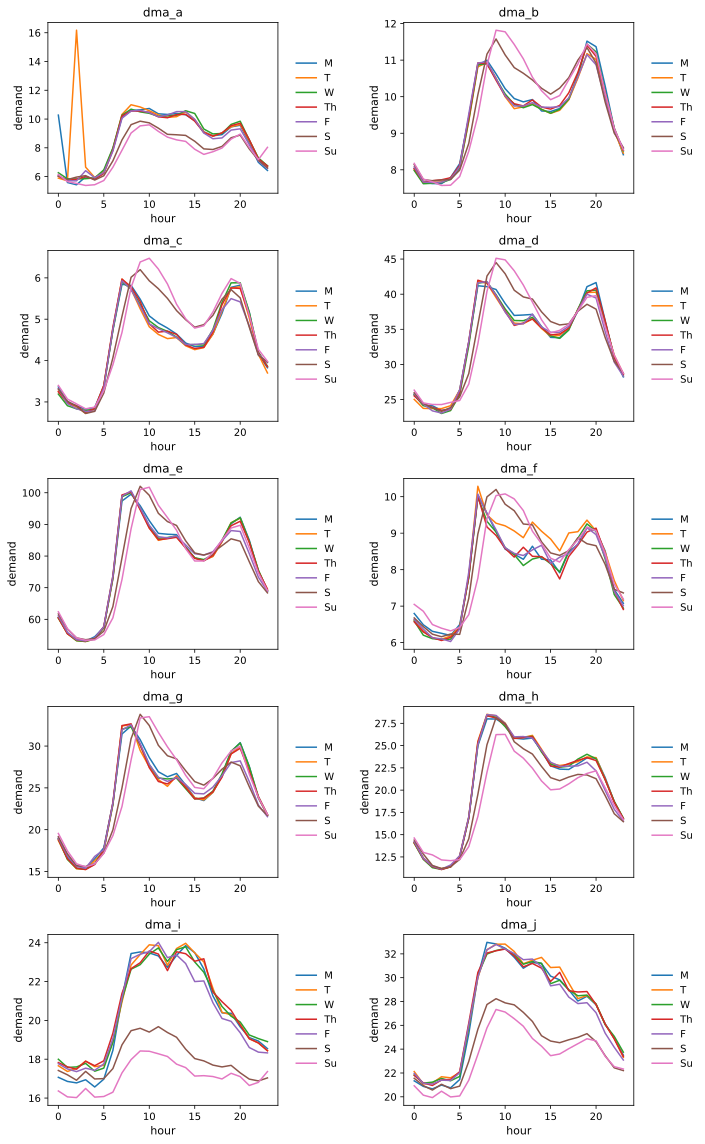

In [80]:
# plotting weekday averages
inflow_data['day'] = inflow_data.index.weekday
inflow_data['hour'] = inflow_data.index.hour

days = ['M', 'T', 'W', 'Th', 'F', 'S', 'Su']

fig, axs = plt.subplots(5, 2, figsize=(10, 16))
axs = axs.flatten()

for i, dma in enumerate(inflow_data.iloc[:, :10].columns):
    for day in np.arange(7): 
        axs[i].plot(inflow_data[inflow_data['day']==day].groupby(by='hour').mean()[dma], label=days[day])
        axs[i].set_title(dma)
        axs[i].set_xlabel('hour')
        axs[i].set_ylabel('demand')
        leg = axs[i].legend(loc='right', bbox_to_anchor=(1.3, 0.5),
            fancybox=False, shadow=False, ncol=1, edgecolor='w', borderpad=0.5)
        leg.get_frame().set_linewidth(0.5)

fig.tight_layout()
plt.show()